In [1]:
import hdbscan
import debacl
import fastcluster
import sklearn.cluster
import scipy.cluster
import gensim
from sklearn.manifold import TSNE

INFO (2018-04-11 05:42:33): 'pattern' package not found; tag filters are not available for English


In [2]:
import random
import sklearn.datasets
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

In [3]:
def benchmark_algorithm(dataset, dataset_sizes, cluster_function, function_args, function_kwds):
    
    result = np.nan * np.ones((len(dataset_sizes)))
    labels = {}
    for index, size in enumerate(dataset_sizes):
            
            data = dataset[index]
            # Start the clustering with a timer
            start_time = time.time()
            k = cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            
            result[index] = time_taken
            try:
                labels[index] = k.labels_
            except:
                labels[index] = k
                
    # Return the result as a dataframe for easier handling with seaborn afterwards
    return result, labels

In [4]:
def to_df(data, sizes):
    return pd.DataFrame(np.vstack([sizes, data.flatten()]).T, columns=['x','y'])

In [5]:
def create_word_vec(models, nork='n'):
    word_vecs = [model.wv for model in models]
    if nork=='n':
        data_sizes = [len(word_vect.vocab) for word_vect in word_vecs]
    else:
        data_sizes = [len(word_vect.syn0[0]) for word_vect in word_vecs]
    w2v = [dict(zip(word_vect.index2word,word_vect.syn0)) for 
           word_vect in word_vecs]
    return data_sizes, w2v

Get data

In [6]:
text_file_name = 'wikipedia.txt'

For increasing data size (n)

In [8]:
data = [gensim.models.word2vec.LineSentence(text_file_name, limit=i) for i in range(100,100000,10000)]

In [8]:
simple_models = [gensim.models.Word2Vec(i, size=10, window=5,
                                      min_count=5, workers=8) for i in data]

WARNING (2018-04-11 04:32:48): consider setting layer size to a multiple of 4 for greater performance
INFO (2018-04-11 04:32:48): collecting all words and their counts
INFO (2018-04-11 04:32:48): PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO (2018-04-11 04:32:48): collected 773 word types from a corpus of 2224 raw words and 100 sentences
INFO (2018-04-11 04:32:48): Loading a fresh vocabulary
INFO (2018-04-11 04:32:48): min_count=5 retains 75 unique words (9% of original 773, drops 698)
INFO (2018-04-11 04:32:48): min_count=5 leaves 1231 word corpus (55% of original 2224, drops 993)
INFO (2018-04-11 04:32:48): deleting the raw counts dictionary of 773 items
INFO (2018-04-11 04:32:48): sample=0.001 downsamples 75 most-common words
INFO (2018-04-11 04:32:48): downsampling leaves estimated 389 word corpus (31.6% of prior 1231)
INFO (2018-04-11 04:32:48): estimated required memory for 75 words and 10 dimensions: 43500 bytes
INFO (2018-04-11 04:32:48): resetting laye

In [9]:
n_sizes, w2v_large_n = create_word_vec(simple_models, 'n')

In [38]:
np.array(n_sizes)[0,1]

IndexError: too many indices for array

In [43]:
def plot_TSNE(data, labels):
    digits_proj = TSNE(random_state=1).fit_transform(list(data.values()))
    plt.figure(figsize=(25,10))
    plt.xlabel('Component #1')
    plt.ylabel('Component #2')
    indices = random.sample([i for i in range(len(digits_proj[:,0]))],100)
    for label, x, y in np.array(list(zip(list(data.keys()), digits_proj[:,0], digits_proj[:,1])))[indices]:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), size='small', textcoords='offset points')
    plt.scatter(digits_proj[:,0], digits_proj[:,1], c=labels)
    #plt.savefig('Kmeans.png')

In [12]:
w2v_large_n_vecs = [list(w.values()) for w in w2v_large_n]

In [13]:
k_means = sklearn.cluster.KMeans(10)
k_means_data, k_labels = benchmark_algorithm(w2v_large_n_vecs, n_sizes, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=0.2)
dbscan_data, db_labels = benchmark_algorithm(w2v_large_n_vecs, n_sizes, dbscan.fit, (), {})

scipy_single_data, h_labels = benchmark_algorithm(w2v_large_n_vecs, n_sizes,
                                        scipy.cluster.hierarchy.complete, (), {})

In [44]:
plot_TSNE(w2v_large_n[1], k_labels[1])

AttributeError: 'NoneType' object has no attribute 'seq'

In [181]:
from scipy.cluster.hierarchy import dendrogram

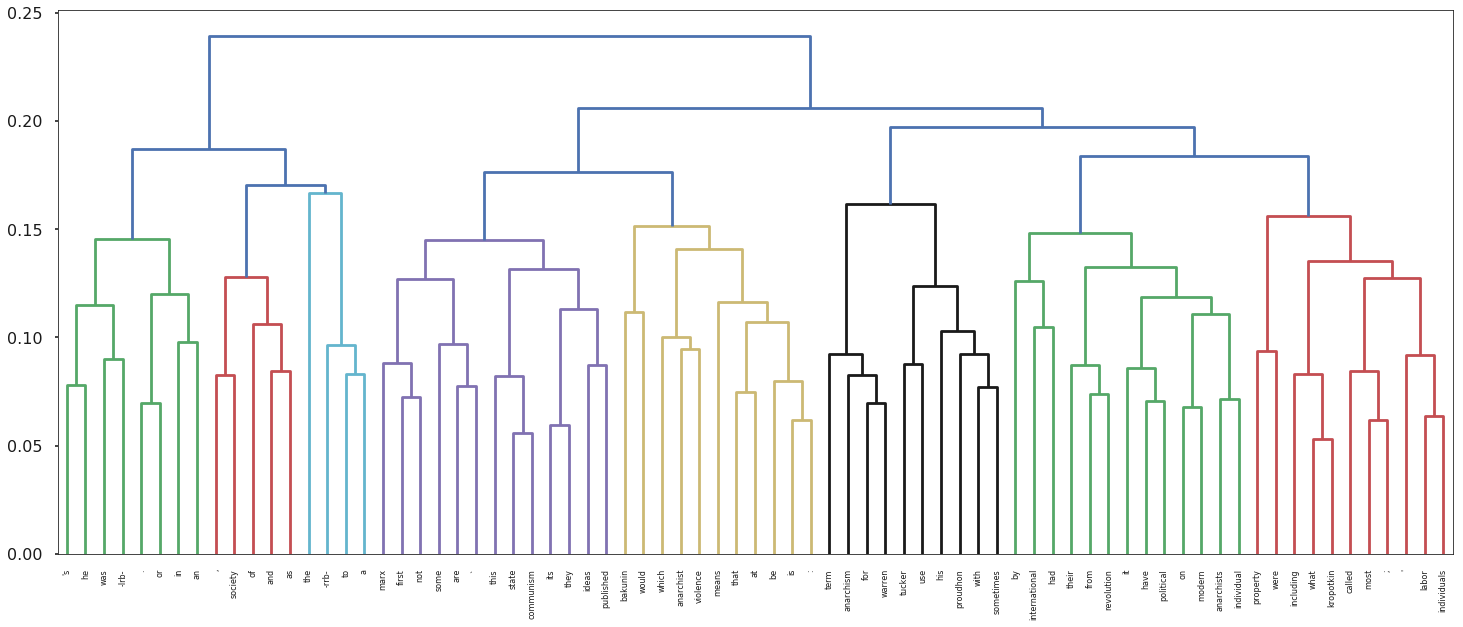

In [196]:
plt.figure(figsize=(25,10))
dendrogram(h_labels[0], labels=list(w2v_large_n[0].keys()), leaf_rotation=90., leaf_font_size=8.,)
plt.show()

In [ ]:
fastclust_data = benchmark_algorithm(w2v_large_n_vecs, n_sizes,
                                     fastcluster.linkage_vector, (), {})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(w2v_large_n_vecs, n_sizes,
                               agglomerative.fit, (), {})

spectral = sklearn.cluster.SpectralClustering(10)
spectral_data = benchmark_algorithm(w2v_large_n_vecs, n_sizes,
                                    spectral.fit, (), {})

affinity_prop = sklearn.cluster.AffinityPropagation()
ap_data = benchmark_algorithm(w2v_large_n_vecs, n_sizes,
                              affinity_prop.fit, (), {})

/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


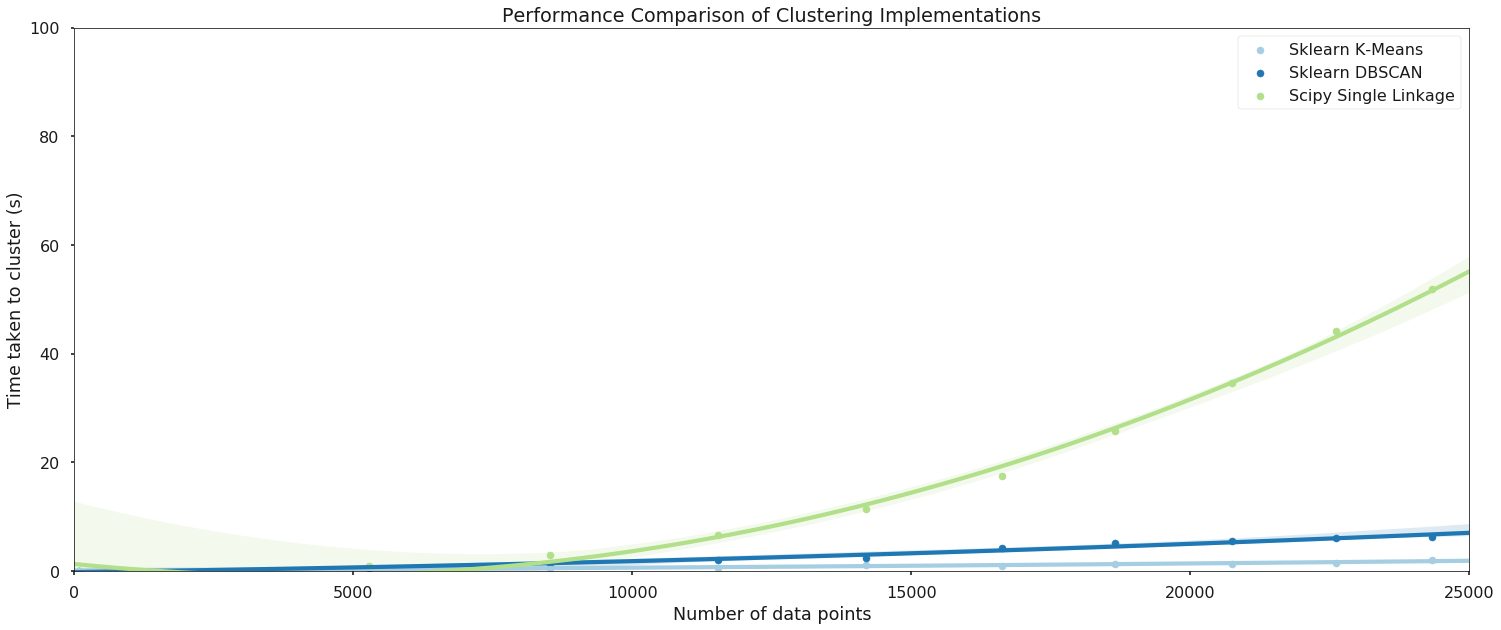

In [51]:
plt.figure(figsize=(25,10))
sns.regplot(x='x', y='y', data=to_df(k_means_data, n_sizes), order=2,
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=to_df(dbscan_data, n_sizes), order=2,
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=to_df(scipy_single_data, n_sizes), order=2,
            label='Scipy Single Linkage', x_estimator=np.mean)

plt.gca().axis([0, 25000, 0, 100])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()
plt.savefig('large_n_plot.png')

For high dimensionality (large k)

In [11]:
data_dim = data[0]

In [12]:
dim_models = [gensim.models.Word2Vec(data_dim, size=i, window=5,
                                      min_count=5, workers=16) for i in range(5000,50000,5000)]

INFO (2018-04-11 05:49:34): collecting all words and their counts
INFO (2018-04-11 05:49:34): PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO (2018-04-11 05:49:34): collected 773 word types from a corpus of 2224 raw words and 100 sentences
INFO (2018-04-11 05:49:34): Loading a fresh vocabulary
INFO (2018-04-11 05:49:34): min_count=5 retains 75 unique words (9% of original 773, drops 698)
INFO (2018-04-11 05:49:34): min_count=5 leaves 1231 word corpus (55% of original 2224, drops 993)
INFO (2018-04-11 05:49:34): deleting the raw counts dictionary of 773 items
INFO (2018-04-11 05:49:34): sample=0.001 downsamples 75 most-common words
INFO (2018-04-11 05:49:34): downsampling leaves estimated 389 word corpus (31.6% of prior 1231)
INFO (2018-04-11 05:49:34): estimated required memory for 75 words and 5000 dimensions: 3037500 bytes
INFO (2018-04-11 05:49:34): resetting layer weights
INFO (2018-04-11 05:49:34): training model with 16 workers on 75 vocabulary and 5000 fea

In [13]:
k_sizes, w2v_large_k = create_word_vec(dim_models, 'k')

In [14]:
w2v_large_k_vecs = [list(w.values()) for w in w2v_large_k]

In [15]:
k_means_dim = sklearn.cluster.KMeans(10)
k_means_dimdata, k_dimlabels = benchmark_algorithm(w2v_large_k_vecs, k_sizes, k_means_dim.fit, (), {})

dbscan_dim = sklearn.cluster.DBSCAN(eps=0.2)
dbscan_dimdata, db_dimlabels = benchmark_algorithm(w2v_large_k_vecs, k_sizes, dbscan_dim.fit, (), {})

scipy_single_dimdata, h_dimlabels = benchmark_algorithm(w2v_large_k_vecs, k_sizes,
                                        scipy.cluster.hierarchy.complete, (), {})

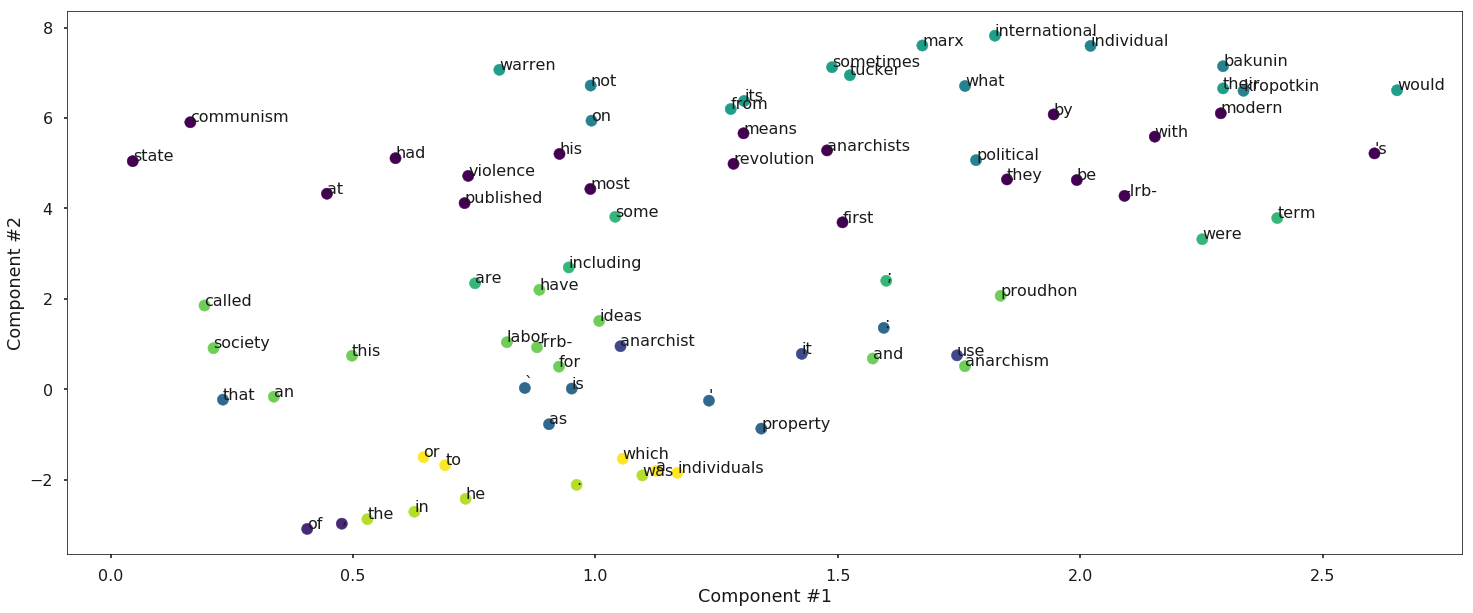

In [263]:
plot_TSNE(w2v_large_k[3],k_dimlabels[3] )

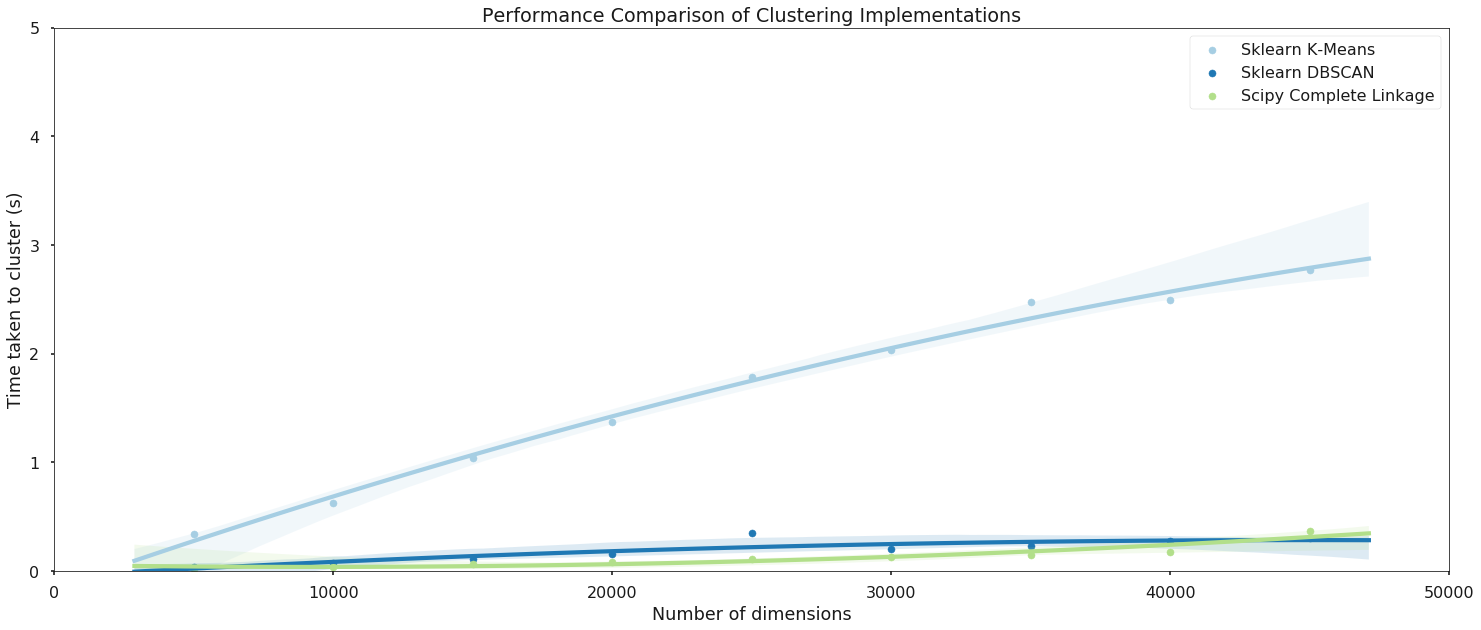

In [16]:
plt.figure(figsize=(25,10))
sns.regplot(x='x', y='y', data=to_df(k_means_dimdata, k_sizes), order=2,
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=to_df(dbscan_dimdata, k_sizes), order=2,
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=to_df(scipy_single_dimdata, k_sizes), order=2,
            label='Scipy Complete Linkage', x_estimator=np.mean)

plt.gca().axis([0, 50000, 0, 5])
plt.gca().set_xlabel('Number of dimensions')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()
plt.savefig('large_k_plot.png')